In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
%matplotlib inline

# Now let's delve into USA monthly data

In [2]:
df_us = pd.read_csv('../data/measurement_record_2009-2019/us_monthly_throughput.csv')

In [3]:
df_us.head()

,country,year,month,throughput
0,United States,2009,2,1.989645
1,United States,2009,3,2.925794
2,United States,2009,4,2.131269
3,United States,2009,5,2.048989
4,United States,2009,6,2.722620


In [4]:
df_us['date'] = pd.to_datetime(df_us['year'].astype(str) + '-' + df_us['month'].astype(str))
df_us.set_index('date', inplace=True)
df_us.drop(['country', 'year', 'month'], axis=1, inplace=True)

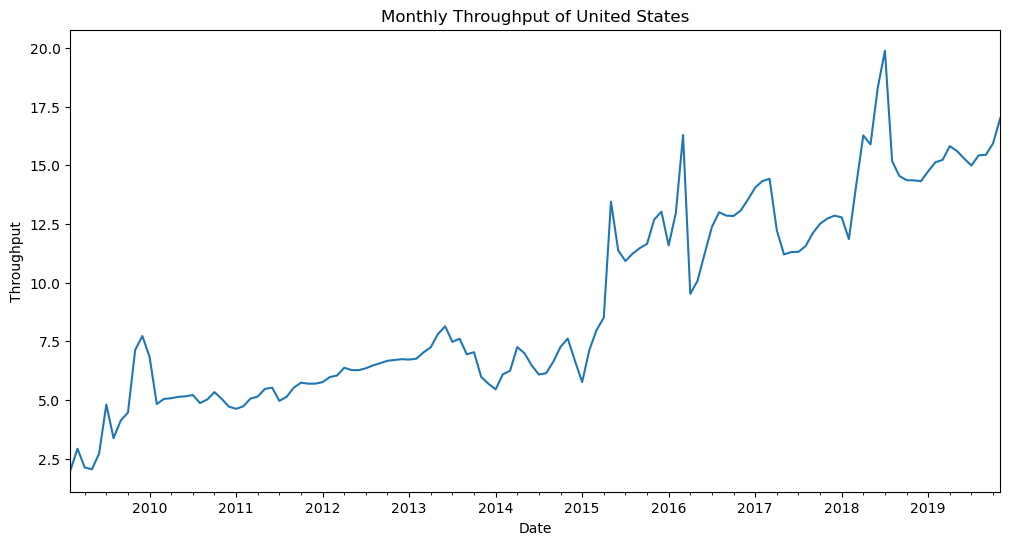

In [5]:
df_us['throughput'].plot(figsize=(12, 6))
plt.title('Monthly Throughput of United States')
plt.xlabel('Date')
plt.ylabel('Throughput')
plt.show()

In [6]:
df_us_filtered = pd.read_csv('../data/measurement_record_2009-2019/us_monthly_throughput_filtered.csv')

In [7]:
df_us_filtered

,year,month,avg_throughput
0,2011,1,8.882980
1,2011,2,27.642125
2,2011,3,14.330196
3,2011,5,16.067541
4,2011,6,12.821957
...,...,...,...
90,2018,8,22.880686
91,2018,9,27.983098
92,2018,10,29.413721
93,2018,11,27.958886


In [8]:
df_us_filtered['date'] = pd.to_datetime(df_us_filtered['year'].astype(str) + '-' + df_us_filtered['month'].astype(str))
df_us_filtered.set_index('date', inplace=True)
df_us_filtered.drop(['year', 'month'], axis=1, inplace=True)

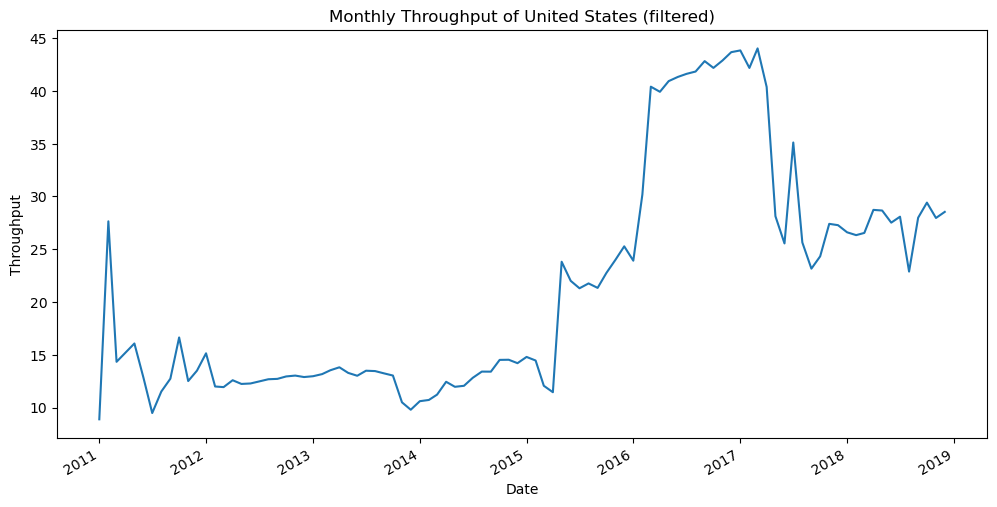

In [9]:
df_us_filtered['avg_throughput'].plot(figsize=(12, 6))
plt.title('Monthly Throughput of United States (filtered)')
plt.xlabel('Date')
plt.ylabel('Throughput')
plt.show()

## Detrend using hpfilter

In [10]:
from statsmodels.tsa.filters.hp_filter import hpfilter

In [11]:
cycle, trend = hpfilter(df_us['throughput'], lamb=14400)

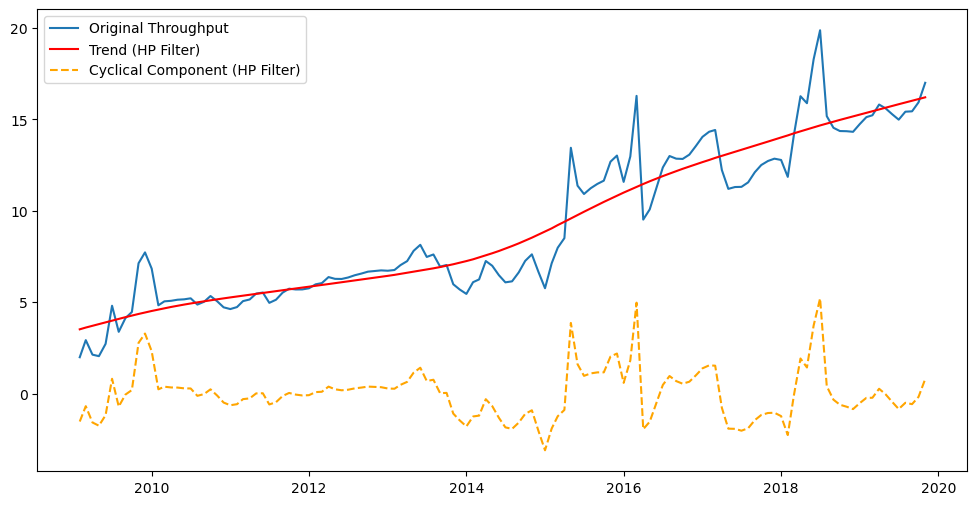

In [12]:
df_us['trend_hp'] = trend
df_us['cycle_hp'] = cycle

# Plot the original data, the trend, and the detrended data
plt.figure(figsize=(12, 6))
plt.plot(df_us['throughput'], label='Original Throughput')
plt.plot(trend, label='Trend (HP Filter)', color='red')
plt.plot(cycle, label='Cyclical Component (HP Filter)', color='orange', linestyle='--')
plt.legend()
plt.show()

## ACF and PACF

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

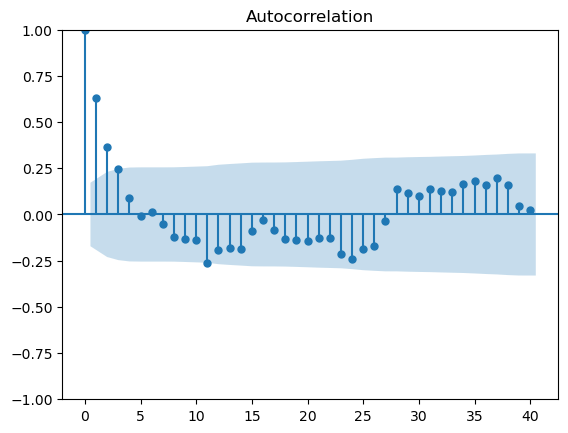

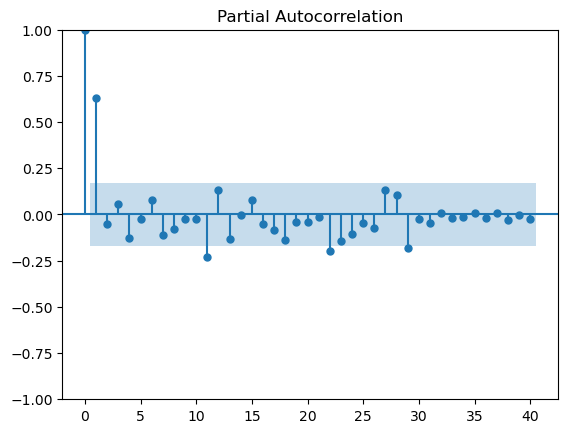

In [14]:
# ACF plot
plot_acf(df_us['cycle_hp'].dropna(), lags=40)
plt.show()

# PACF plot
plot_pacf(df_us['cycle_hp'].dropna(), lags=40)
plt.show()

## ARIMA

In [15]:
from statsmodels.tsa.arima.model import ARIMA

# Fit the ARIMA model
# Note: p, d, and q values should be chosen based on the ACF and PACF plots and domain knowledge
model = ARIMA(df_us['cycle_hp'].dropna(), order=(2,0,3))
results = model.fit()

# Summary of the model
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:               cycle_hp   No. Observations:                  130
Model:                 ARIMA(2, 0, 3)   Log Likelihood                -190.467
Date:                Wed, 20 Mar 2024   AIC                            394.933
Time:                        01:51:37   BIC                            415.006
Sample:                    02-01-2009   HQIC                           403.090
                         - 11-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0043      0.314     -0.014      0.989      -0.621       0.612
ar.L1          0.7012      1.032      0.679      0.497      -1.322       2.724
ar.L2         -0.1933      0.746     -0.259      0.7

/Users/jacky/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jacky/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jacky/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


So the throughput itself does not follow any cycles and the ARIMA model is not evident enough.

## Now we go to do the multivariate time series on quarter data

In [16]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.filters.hp_filter import hpfilter

In [17]:
throughput_rtt_df = pd.read_csv('../data/measurement_record_2009-2019/us_avg_throughtput_rtt_quarterly_2011-2018.csv')

In [18]:
cycle, trend = hpfilter(throughput_rtt_df['avg_throughput'], lamb=1600)

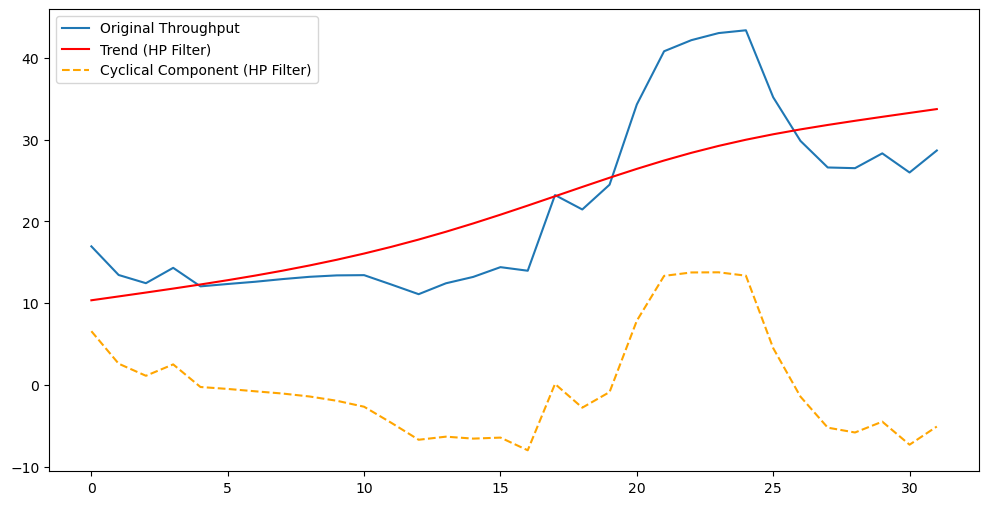

In [19]:
throughput_rtt_df['trend_hp'] = trend
throughput_rtt_df['cycle_hp'] = cycle

# Plot the original data, the trend, and the detrended data
plt.figure(figsize=(12, 6))
plt.plot(throughput_rtt_df['avg_throughput'], label='Original Throughput')
plt.plot(trend, label='Trend (HP Filter)', color='red')
plt.plot(cycle, label='Cyclical Component (HP Filter)', color='orange', linestyle='--')
plt.legend()
plt.show()

In [20]:
throughput_rtt_df.head(3)

,year,quarter,avg_throughput,avg_rtt,trend_hp,cycle_hp
0,2011,1,16.951767,27.000000,10.364469,6.587298
1,2011,2,13.454213,13.064935,10.834894,2.619319
2,2011,3,12.452311,43.958981,11.309437,1.142874


In [21]:
throughput_rtt_df['date'] = throughput_rtt_df['year'].astype(str) + 'Q' + throughput_rtt_df['quarter'].astype(str)
throughput_rtt_df.set_index('date', inplace=True)
throughput_rtt_df.drop(['year', 'quarter'], axis=1, inplace=True)
throughput_rtt_df.head(10) 

,avg_throughput,avg_rtt,trend_hp,cycle_hp
date,,,,
2011Q1,16.951767,27.000000,10.364469,6.587298
2011Q2,13.454213,13.064935,10.834894,2.619319
2011Q3,12.452311,43.958981,11.309437,1.142874
2011Q4,14.327053,43.644628,11.793850,2.533202
2012Q1,12.064873,40.648843,12.294604,-0.229731
2012Q2,12.354573,38.168708,12.819748,-0.465175
2012Q3,12.625260,35.197264,13.377192,-0.751932
2012Q4,12.950294,36.132405,13.974553,-1.024259
2013Q1,13.231334,38.381901,14.618978,-1.387644


In [22]:
gdp_per_capita_df = pd.read_csv('../data/2009-2018 us econ data/us_gdp_per_capita_quarterly_2011-2018.csv')
unemployment_rate_df = pd.read_csv('../data/2009-2018 us econ data/us_unemployment_rate_quarterly_2011-2018.csv')

In [23]:
gdp_per_capita_df['DATE'] = pd.to_datetime(gdp_per_capita_df['DATE'])
gdp_per_capita_df['date'] = gdp_per_capita_df['DATE'].dt.to_period('Q').astype(str)
gdp_per_capita_df.set_index('date', inplace=True)
gdp_per_capita_df.drop('DATE', axis=1, inplace=True)
gdp_per_capita_df.rename(columns={'A939RX0Q048SBEA': 'gdppercapita'}, inplace=True)
gdp_per_capita_df.head(3)

,gdppercapita
date,
2011Q1,54341.0
2011Q2,54610.0
2011Q3,54482.0


In [24]:
unemployment_rate_df['DATE'] = pd.to_datetime(unemployment_rate_df['DATE'])
unemployment_rate_df['date'] = unemployment_rate_df['DATE'].dt.to_period('Q').astype(str)
unemployment_rate_df.set_index('date', inplace=True)
unemployment_rate_df.drop('DATE', axis=1, inplace=True)
unemployment_rate_df.head(3)

,UNRATE
date,
2011Q1,9.033333
2011Q2,9.066667
2011Q3,9.000000


In [25]:
merged_df = throughput_rtt_df.join([gdp_per_capita_df, unemployment_rate_df], how='outer')

In [26]:
merged_df.head(3)

,avg_throughput,avg_rtt,trend_hp,cycle_hp,gdppercapita,UNRATE
date,,,,,,
2011Q1,16.951767,27.000000,10.364469,6.587298,54341.0,9.033333
2011Q2,13.454213,13.064935,10.834894,2.619319,54610.0,9.066667
2011Q3,12.452311,43.958981,11.309437,1.142874,54482.0,9.000000


In [27]:
merged_df = merged_df.drop(['avg_throughput','avg_rtt','cycle_hp'], axis=1)
merged_df.head(3)

,trend_hp,gdppercapita,UNRATE
date,,,
2011Q1,10.364469,54341.0,9.033333
2011Q2,10.834894,54610.0,9.066667
2011Q3,11.309437,54482.0,9.000000


In [28]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.stats.stattools import durbin_watson

In [29]:
merged_df

,trend_hp,gdppercapita,UNRATE
date,,,
2011Q1,10.364469,54341.0,9.033333
2011Q2,10.834894,54610.0,9.066667
2011Q3,11.309437,54482.0,9.000000
2011Q4,11.793850,54979.0,8.633333
2012Q1,12.294604,55342.0,8.266667
2012Q2,12.819748,55490.0,8.200000
2012Q3,13.377192,55454.0,8.033333
2012Q4,13.974553,55403.0,7.800000
2013Q1,14.618978,55859.0,7.733333


In [30]:
def perform_adf_test(series):
    result = adfuller(series, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [31]:
adf_results = {}
for name, column in merged_df.items():
    print(f'Augmented Dickey-Fuller Test on "{name}"')
    perform_adf_test(column)
    print('')  # Print a new line for better readability between result

Augmented Dickey-Fuller Test on "trend_hp"
ADF Statistic: 2.290397
p-value: 0.998949
Critical Values:
	1%: -3.788
	5%: -3.013
	10%: -2.646

Augmented Dickey-Fuller Test on "gdppercapita"
ADF Statistic: 0.829557
p-value: 0.992099
Critical Values:
	1%: -3.770
	5%: -3.005
	10%: -2.643

Augmented Dickey-Fuller Test on "UNRATE"
ADF Statistic: -2.385157
p-value: 0.145970
Critical Values:
	1%: -3.753
	5%: -2.998
	10%: -2.639



In [32]:
merged_df_diff = merged_df.diff().dropna()

In [33]:
merged_df_diff

,trend_hp,gdppercapita,UNRATE
date,,,
2011Q2,0.470425,269.0,0.033333
2011Q3,0.474542,-128.0,-0.066667
2011Q4,0.484414,497.0,-0.366667
2012Q1,0.500753,363.0,-0.366667
2012Q2,0.525145,148.0,-0.066667
2012Q3,0.557444,-36.0,-0.166667
2012Q4,0.597361,-51.0,-0.233333
2013Q1,0.644425,456.0,-0.066667
2013Q2,0.697996,55.0,-0.200000


In [34]:
for name, column in merged_df_diff.items():
    print(f'Augmented Dickey-Fuller Test on "{name}" after differencing')
    perform_adf_test(column)
    print('')  # Print a new line for better readability between results

Augmented Dickey-Fuller Test on "trend_hp" after differencing
ADF Statistic: -3.562418
p-value: 0.006522
Critical Values:
	1%: -3.724
	5%: -2.986
	10%: -2.633

Augmented Dickey-Fuller Test on "gdppercapita" after differencing
ADF Statistic: -3.477726
p-value: 0.008578
Critical Values:
	1%: -3.770
	5%: -3.005
	10%: -2.643

Augmented Dickey-Fuller Test on "UNRATE" after differencing
ADF Statistic: -3.124103
p-value: 0.024820
Critical Values:
	1%: -3.679
	5%: -2.968
	10%: -2.623



### Therefore, the data appears to be stationary after differencing.

In [35]:
model = VAR(merged_df_diff)
selected_lags = model.select_order(maxlags=5)
selected_lags_summary = selected_lags.summary()
print(selected_lags_summary)

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       3.729       3.874       41.64       3.771
1      0.8022       1.383       2.247      0.9694
2      -4.662      -3.646    0.009841      -4.369
3      -5.487      -4.035    0.004692      -5.069
4     -7.099*     -5.212*   0.001111*     -6.555*
5      -6.777      -4.455    0.002103      -6.108
-------------------------------------------------


/Users/jacky/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
/Users/jacky/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


In [36]:
model_fitted = model.fit(4)
model_fitted_summary = model_fitted.summary()
model_fitted_summary

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 20, Mar, 2024
Time:                     01:51:48
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -4.92893
Nobs:                     27.0000    HQIC:                  -6.24412
Log likelihood:           15.8754    FPE:                 0.00144432
AIC:                     -6.80069    Det(Omega_mle):     0.000444196
--------------------------------------------------------------------
Results for equation trend_hp
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                   0.008358         0.002648            3.156           0.002
L1.trend_hp             3.524554         0.151073           23.330           0.000
L1.gdppercapita         0.000000         0.000002

In [37]:
durbin_watson_results = durbin_watson(model_fitted.resid)

# Let's create a more readable format for the Durbin Watson results
durbin_watson_dict = {}
for col, val in zip(merged_df_diff.columns, durbin_watson_results):
    durbin_watson_dict[col] = round(val, 2)

durbin_watson_dict

{'trend_hp': 2.19, 'gdppercapita': 2.4, 'UNRATE': 2.22}

/var/folders/84/q55wppkx3832k2wsylj8gt3w0000gn/T/ipykernel_37309/1200285599.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  irf_plot.show()


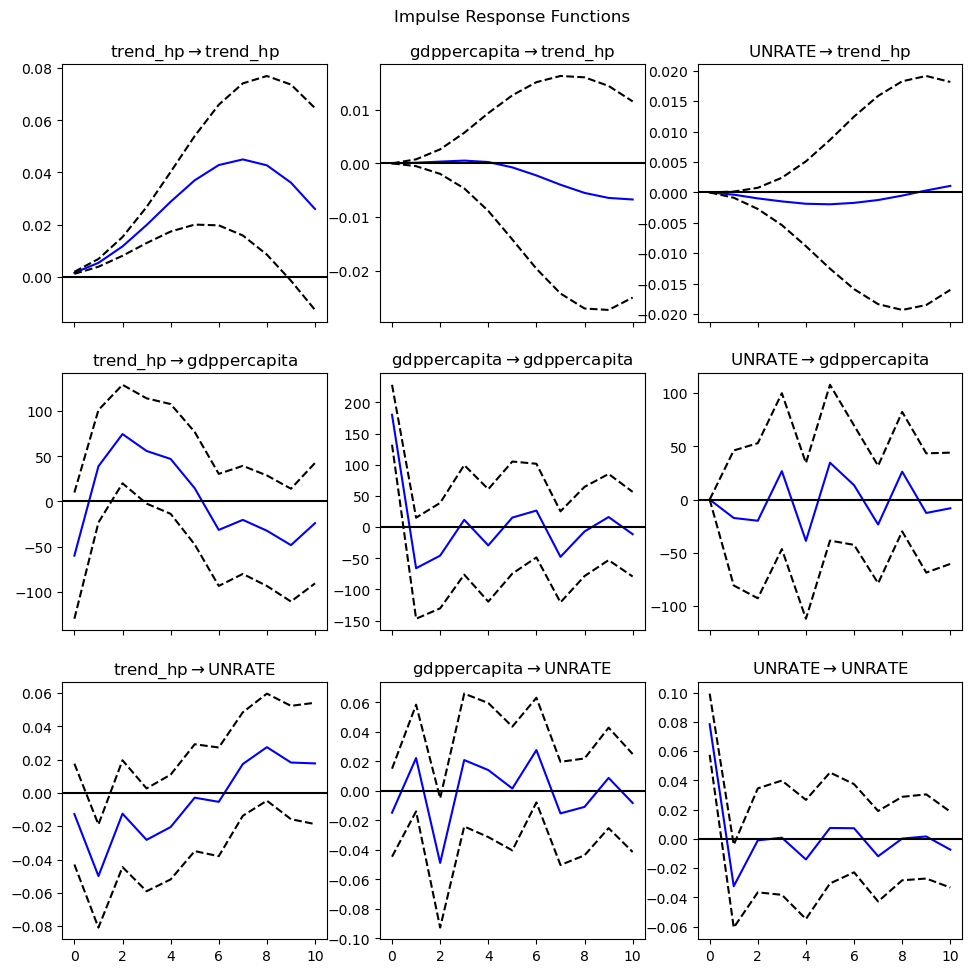

In [38]:
irf = model_fitted.irf(periods=10)  # 10 periods impulse response

# Plot the impulse response functions
irf_plot = irf.plot(orth=True)  # orth=True for orthogonalized impulse response functions
irf_plot.suptitle('Impulse Response Functions', fontsize=12)  # Title for the plots

# The plot will show the response of all variables in the system to one standard deviation shocks
# to each of the variables over 10 periods (quarters).
irf_plot.show()

FEVD for trend_hp
     trend_hp  gdppercapita    UNRATE
0    1.000000      0.000000  0.000000
1    0.995199      0.000405  0.004396
2    0.992726      0.000701  0.006573
3    0.993505      0.000671  0.005823
4    0.994846      0.000314  0.004840
5    0.995825      0.000364  0.003811
6    0.995760      0.001314  0.002925
7    0.994453      0.003286  0.002262
8    0.992085      0.006115  0.001800
9    0.988963      0.009473  0.001565

FEVD for gdppercapita
     trend_hp  gdppercapita    UNRATE
0    0.099594      0.900406  0.000000
1    0.120991      0.871918  0.007092
2    0.212275      0.773888  0.013837
3    0.254286      0.719724  0.025990
4    0.272103      0.678282  0.049615
5    0.268223      0.663638  0.068139
6    0.276028      0.654945  0.069027
7    0.268718      0.657271  0.074011
8    0.277135      0.640595  0.082270
9    0.299525      0.619174  0.081301

FEVD for UNRATE
     trend_hp  gdppercapita    UNRATE
0    0.024640      0.033744  0.941616
1    0.251164      0.067635  0

/var/folders/84/q55wppkx3832k2wsylj8gt3w0000gn/T/ipykernel_37309/69676401.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fevd_plot.show()


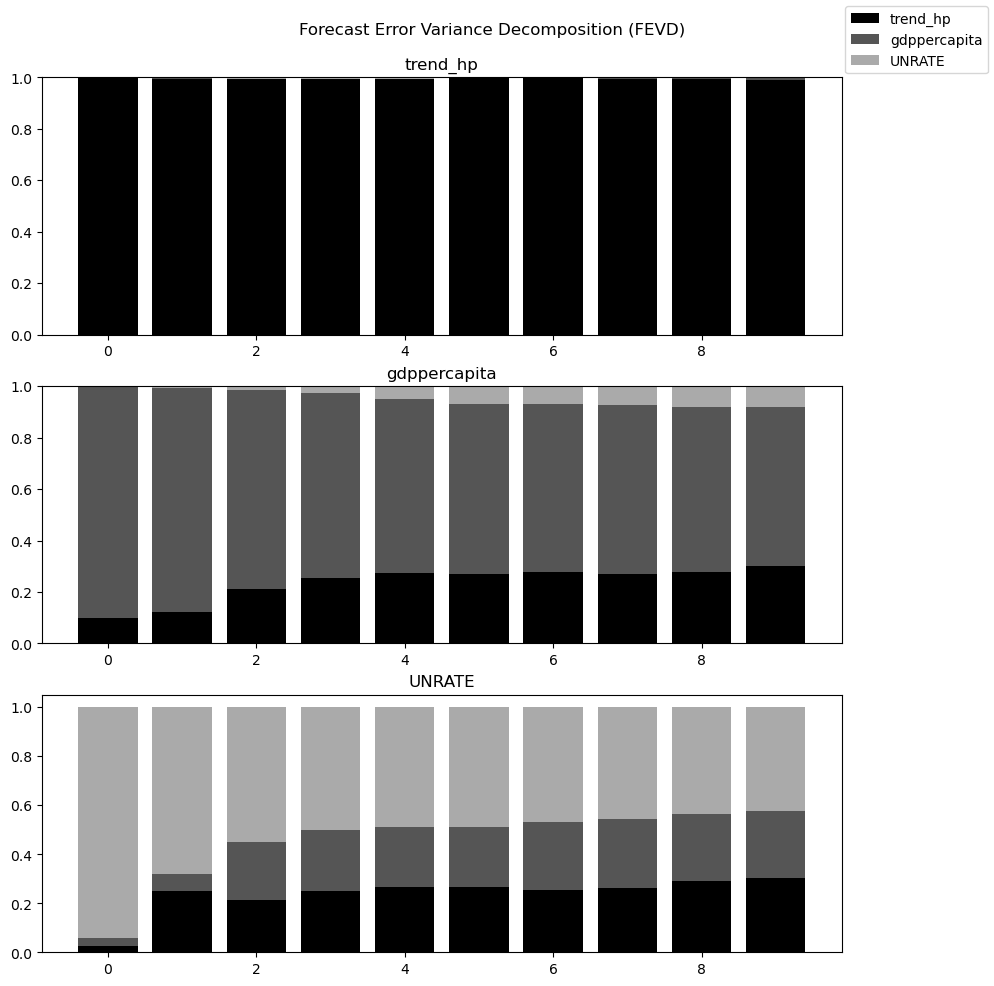

In [39]:
fevd = model_fitted.fevd(periods=10)  # Analyze over 10 periods
fevd_results = fevd.summary()

# Plot the FEVD results
fevd_plot = fevd.plot()
fevd_plot.suptitle('Forecast Error Variance Decomposition (FEVD)', fontsize=12)  # Title for the plots

# The FEVD plot shows the proportion of the forecast error variance in each variable that is attributable
# to shocks to each of the other variables in the system.
fevd_plot.show()

fevd_results